<a href="https://colab.research.google.com/github/Poojan3108/Mapping-of-Possible-Terrestrial-Habitat-for-Wildlife/blob/main/Possible_Terrestrial_Wildlife_Habitat_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:


! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download quadeer15sh/augmented-forest-segmentation

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
!unzip '/content/augmented-forest-segmentation.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_01.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_03.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_04.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_11.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_m

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate ,BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50


In [ ]:
def load_images_from_directory(directory, target_size):
    images = []
    for filename in sorted(os.listdir(directory)):
        img_path = os.path.join(directory, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

In [ ]:
def load_masks_from_directory(directory, target_size):
    masks = []
    for filename in sorted(os.listdir(directory)):
        mask_path = os.path.join(directory, filename)
        mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")  # Load as grayscale
        mask_array = img_to_array(mask)
        masks.append(mask_array)
    return np.array(masks)

In [ ]:
image_dir = '/content/Forest Segmented/Forest Segmented/images'
mask_dir = '/content/Forest Segmented/Forest Segmented/masks'
target_size = (128, 128)

In [ ]:
images = load_images_from_directory(image_dir, target_size) / 255.0
masks = load_masks_from_directory(mask_dir, target_size) / 255.0


In [ ]:
def display_sample(images, masks, index=0,num_sample=1):

    for i in range(num_sample):
        plt.figure(figsize=(5, 2.5))

        sample_index = index + i

        plt.subplot(1, 2, 1)
        plt.title("Sample Image")
        plt.imshow(images[sample_index])
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Sample Mask")
        plt.imshow(masks[sample_index].squeeze(), cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

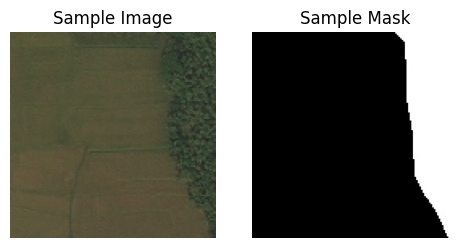

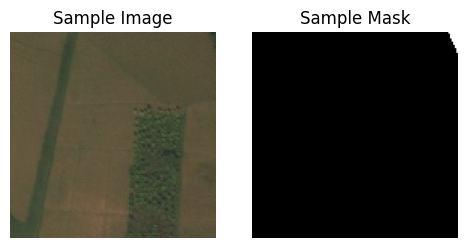

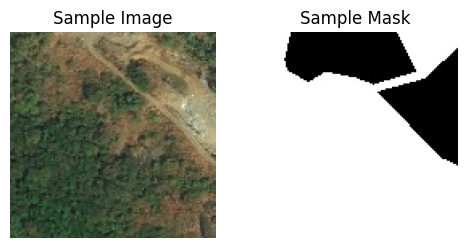

In [ ]:
display_sample(images,masks,index=0,num_sample=3)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(images,masks,test_size=0.2,random_state=42)

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(images,masks,test_size=0.2,random_state=42)

In [ ]:
image_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    # horizontal_flip=True,
    # brightness_range=[0.8, 1.2],  # Brightness adjustments
    fill_mode='nearest'
)

In [ ]:
image_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    # horizontal_flip=True,
    # brightness_range=[0.8, 1.2],  # Brightness adjustments
    fill_mode='nearest'
)
mask_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    # horizontal_flip=True,
    # brightness_range=[0.8, 1.2],  # Brightness adjustments
    fill_mode='nearest'
)

In [ ]:
seed = 42
train_image_generator = image_datagen.flow(x_train, batch_size=16, seed=seed)
train_mask_generator = mask_datagen.flow(y_train, batch_size=16, seed=seed)
val_image_generator = image_datagen.flow(x_val, batch_size=16, seed=seed)
val_mask_generator = mask_datagen.flow(y_val, batch_size=16, seed=seed)

In [ ]:
def combine_generators(image_generator, mask_generator):
    for img, mask in zip(image_generator, mask_generator):
        yield img, mask

In [ ]:
batch_size = 8
steps_per_epoch = len(train_image_generator)
validation_steps = len(val_image_generator)

train_generator = combine_generators(train_image_generator, train_mask_generator)
val_generator = combine_generators(val_image_generator, val_mask_generator)

In [ ]:
def DeepLabV3Plus(input_shape=(128, 128, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Backbone - Pre-trained ResNet50 (without top layers)
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    # ASPP
    x = base_model.get_layer("conv4_block6_out").output

    aspp1 = layers.Conv2D(256, (1, 1), padding="same", activation="relu")(x)
    aspp1 = layers.BatchNormalization()(aspp1)

    aspp2 = layers.Conv2D(256, (3, 3), padding="same", dilation_rate=6, activation="relu")(x)
    aspp2 = layers.BatchNormalization()(aspp2)

    aspp3 = layers.Conv2D(256, (3, 3), padding="same", dilation_rate=12, activation="relu")(x)
    aspp3 = layers.BatchNormalization()(aspp3)

    aspp4 = layers.Conv2D(256, (3, 3), padding="same", dilation_rate=18, activation="relu")(x)
    aspp4 = layers.BatchNormalization()(aspp4)

    avg_pool = layers.GlobalAveragePooling2D()(x)
    avg_pool = layers.Reshape((1, 1, avg_pool.shape[-1]))(avg_pool)
    avg_pool = layers.Conv2D(256, (1, 1), padding="same", activation="relu")(avg_pool)
    avg_pool = layers.BatchNormalization()(avg_pool)

    # Fix: Use dynamic resizing
    avg_pool = layers.UpSampling2D(
        size=(x.shape[1] // avg_pool.shape[1], x.shape[2] // avg_pool.shape[2]),
        interpolation="bilinear"
    )(avg_pool)

    # Concatenate ASPP features
    aspp = layers.Concatenate()([aspp1, aspp2, aspp3, aspp4, avg_pool])
    aspp = layers.Conv2D(256, (1, 1), padding="same", activation="relu")(aspp)
    aspp = layers.BatchNormalization()(aspp)
    aspp = layers.Dropout(0.5)(aspp)  # Dropout added

    # Decoder
    low_level_features = base_model.get_layer("conv2_block3_out").output
    low_level_features = layers.Conv2D(48, (1, 1), padding="same", activation="relu")(low_level_features)
    low_level_features = layers.BatchNormalization()(low_level_features)

    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(aspp)
    x = layers.Concatenate()([x, low_level_features])

    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # L2 regularization added
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)  # Dropout added
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # L2 regularization added
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)  # Dropout added

    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    outputs = layers.Conv2D(num_classes, (1, 1), padding="same", activation="sigmoid")(x)

    model = models.Model(inputs, outputs, name="DeepLabV3Plus")

    return model

In [ ]:
input_shape = (128, 128, 3)
model = DeepLabV3Plus(input_shape=input_shape, num_classes=1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.summary()

Model: "DeepLabV3Plus"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 17,832,305 (68.02 MB)

 Trainable params: 17,797,521 (67.89 MB)

 Non-trainable params: 34,784 (135.88 KB)

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=35,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]  # Pass callbacks
)

Epoch 1/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 208s 478ms/step - accuracy: 0.7203 - loss: 1.0866 - mean_io_u: 0.2014 - val_accuracy: 0.3778 - val_loss: 55.1008 - val_mean_io_u: 0.2057 - learning_rate: 1.0000e-04
Epoch 2/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 64s 250ms/step - accuracy: 0.7843 - loss: 0.8989 - mean_io_u: 0.2058 - val_accuracy: 0.3861 - val_loss: 7.1170 - val_mean_io_u: 0.2100 - learning_rate: 1.0000e-04
Epoch 3/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 63s 248ms/step - accuracy: 0.7982 - loss: 0.8018 - mean_io_u: 0.1999 - val_accuracy: 0.3795 - val_loss: 6.0725 - val_mean_io_u: 0.2063 - learning_rate: 1.0000e-04
Epoch 4/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 83s 323ms/step - accuracy: 0.8113 - loss: 0.7183 - mean_io_u: 0.1976 - val_accuracy: 0.4735 - val_loss: 2.1924 - val_mean_io_u: 0.2060 - learning_rate: 1.0000e-04
Epoch 5/35
256/256 ━━━━━━━━━━━━━━━━━━━━ 64s 249ms/step - accuracy: 0.8096 - loss: 0.6526 - mean_io_u: 0.2028 - val_accuracy: 0.8088 - val_loss: 0.6319 - val_mean_io_u: 0.2064 - learning_

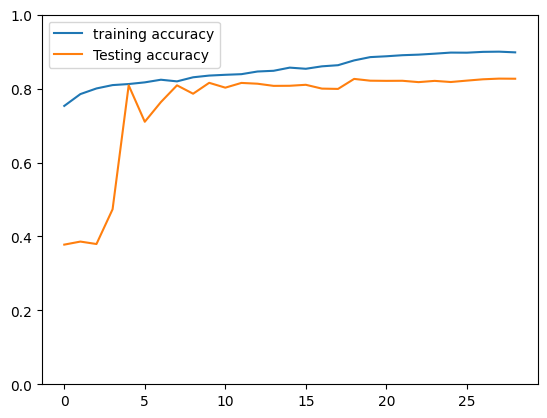

In [ ]:
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='Testing accuracy')
plt.legend()
plt.ylim([0,1])
plt.savefig("accuracyvsepochs.png")
plt.show()

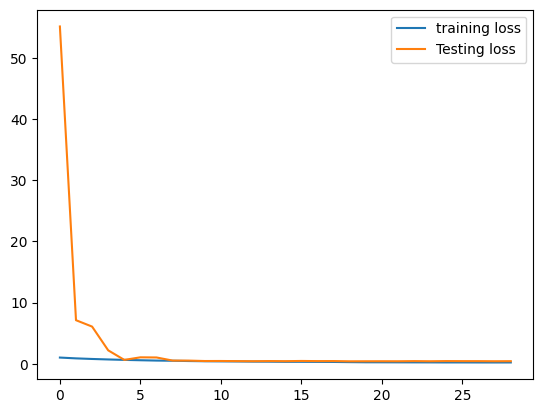

In [ ]:
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='Testing loss')
plt.legend()
plt.savefig("lossvsepochs.png")
plt.show()

In [ ]:
test_loss, test_accuracy, test_miou = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test mIoU: {test_miou}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 574ms/step - accuracy: 0.8376 - loss: 0.4131 - mean_io_u: 0.1978
Test Loss: 0.42611607909202576, Test Accuracy: 0.8327708840370178, Test mIoU: 0.20089228451251984


In [ ]:
predicted_masks = model.predict(x_test)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)  # Threshold for binary masks

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 274ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = (y_test > 0.5).astype(np.uint8).flatten()  # Threshold and flatten
y_pred = predicted_masks.flatten()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Background", "Foreground"]))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

Classification Report:
              precision    recall  f1-score   support

  Background       0.81      0.78      0.79   6616033
  Foreground       0.86      0.88      0.87  10128415

    accuracy                           0.84  16744448
   macro avg       0.83      0.83      0.83  16744448
weighted avg       0.84      0.84      0.84  16744448

Confusion Matrix:
[[5180706 1435327]
 [1243255 8885160]]


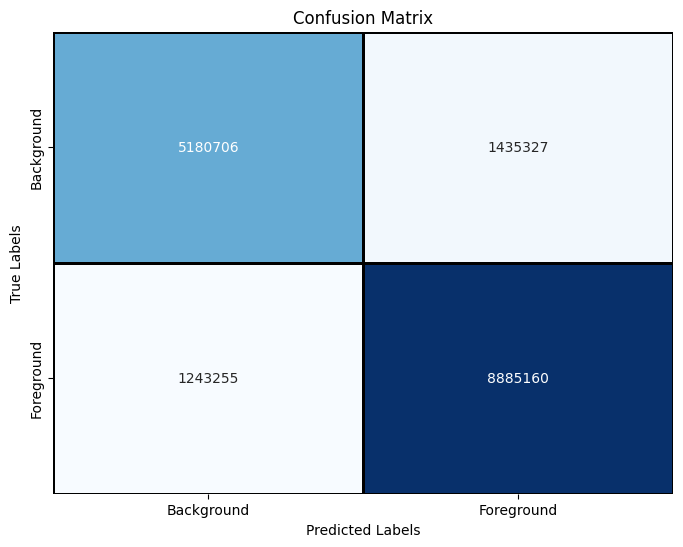

In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False,
        linewidths=1,
        linecolor="black"
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


class_names = ["Background", "Foreground"]
plot_confusion_matrix(cm, class_names)

In [ ]:
def display_results(x_test, y_test, predicted_masks, index=0):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Create subplots and get axes

    axes[0].set_title("Test Image")
    axes[0].imshow(x_test[index])
    axes[0].axis('off')
    fig.savefig(f"test_image_{index}.png")  # Save the test image

    axes[1].set_title("Ground Truth Mask")
    axes[1].imshow(y_test[index].squeeze(), cmap='gray')
    axes[1].axis('off')
    fig.savefig(f"ground_truth_mask_{index}.png")  # Save the ground truth mask

    axes[2].set_title("Predicted Mask")
    axes[2].imshow(predicted_masks[index].squeeze(), cmap='gray')
    axes[2].axis('off')
    fig.savefig(f"predicted_mask_{index}.png")  # Save the predicted mask

    plt.close(fig)  # Close the figure to release resources


for i in range(4):
    display_results(x_test, y_test, predicted_masks, index=i)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step


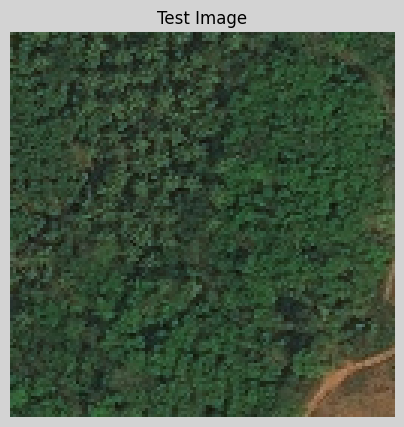

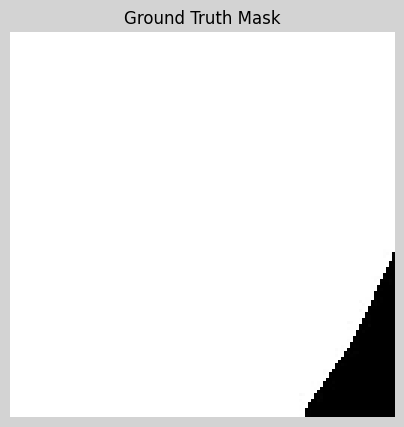

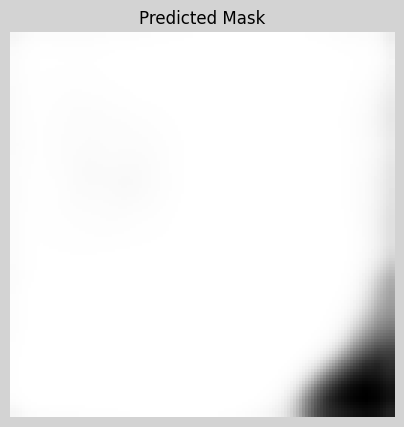

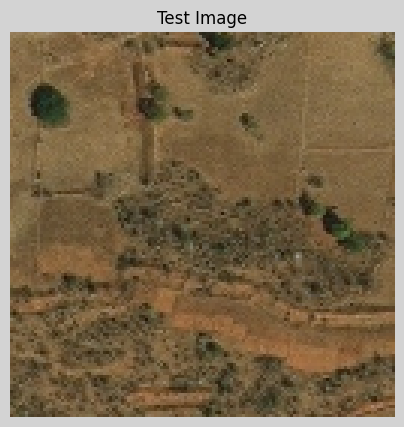

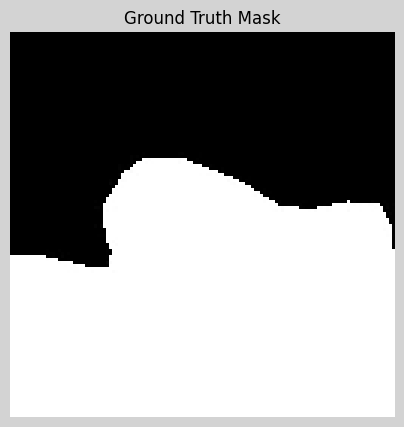

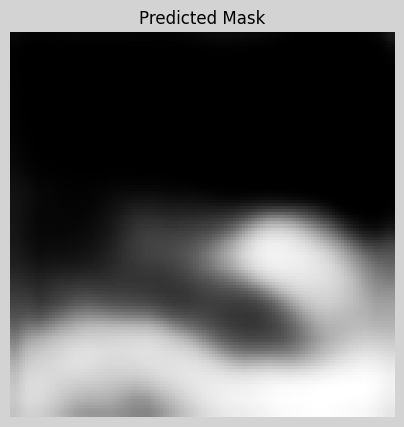

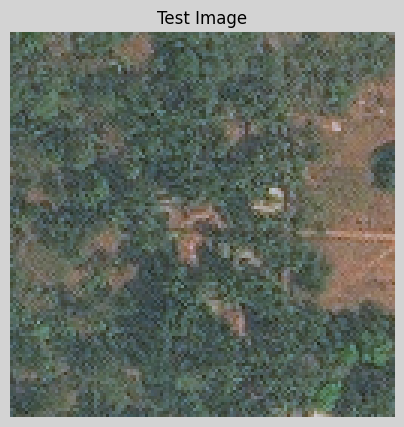

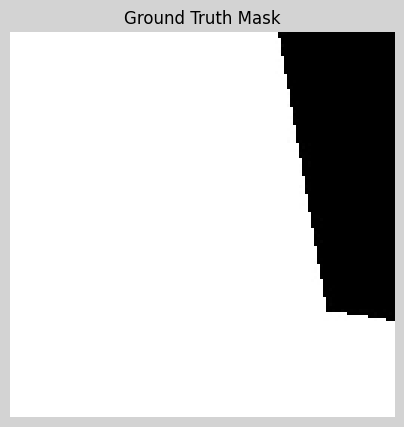

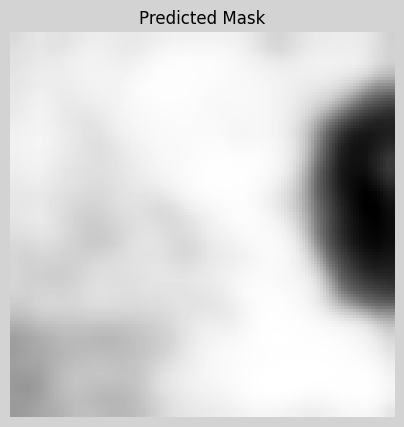

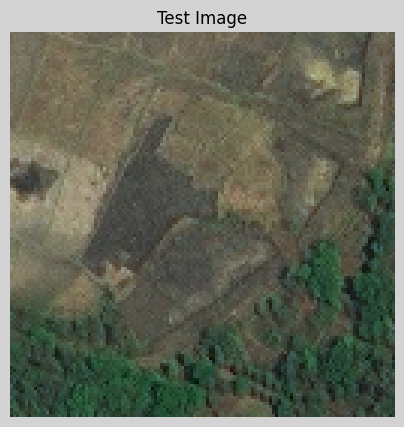

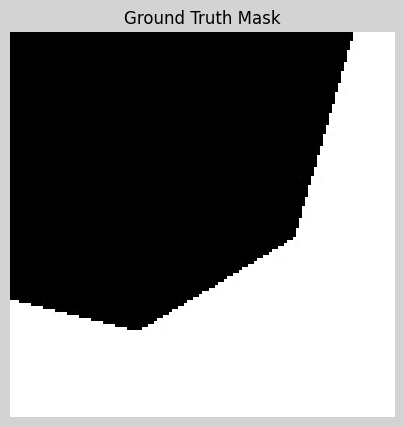

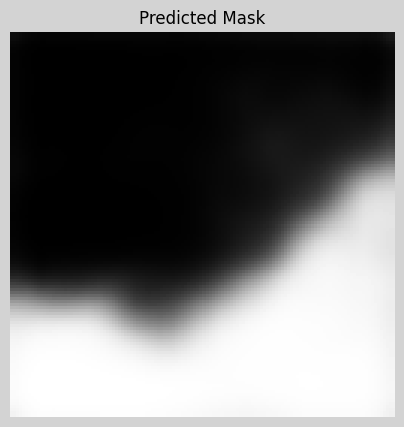

In [ ]:
def display_results(x_test, y_test, predicted_masks, index=0):
    # Original Image
    plt.figure(figsize=(5, 5), facecolor='lightgray')  # Set background to black
    plt.title("Test Image", color='black')  # Set title color to white
    plt.imshow(x_test[index])
    plt.axis('off')
    plt.savefig(f"test_image_{index}.png", dpi=300, facecolor='lightgray')
    plt.show()

    # Ground Truth Mask
    plt.figure(figsize=(5, 5), facecolor='lightgray')  # Set background to black
    plt.title("Ground Truth Mask", color='black')  # Set title color to white
    plt.imshow(y_test[index].squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig(f"ground_truth_{index}.png", dpi=300, facecolor='lightgray')
    plt.show()

    # Predicted Mask
    plt.figure(figsize=(5, 5), facecolor='lightgray')  # Set background to black
    plt.title("Predicted Mask", color='black')  # Set title color to white
    plt.imshow(predicted_masks[index].squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig(f"prediction_mask{index}.png", dpi=300, facecolor='lightgray')
    plt.show()

predicted_masks = model.predict(x_test)

for i in range(4):
    display_results(x_test, y_test, predicted_masks, index=i)

In [ ]:
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    sum_squares = np.sum(y_true) + np.sum(y_pred)
    dice_score = (2.0 * intersection + 1) / (sum_squares +1)  # Adding 1 to avoid division by 0
    return dice_score

In [ ]:
# Assuming 'predicted_masks' and 'y_test' are your predictions and ground truth masks
iou_score = calculate_iou(y_test, predicted_masks)
dice_score = calculate_dice(y_test, predicted_masks)

print(f"IoU: {iou_score}")
print(f"Dice Coefficient: {dice_score}")

IoU: 0.6123908675825308
Dice Coefficient: 0.8377018295081082
